0 255


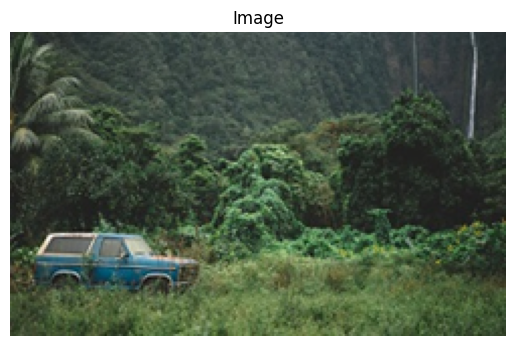

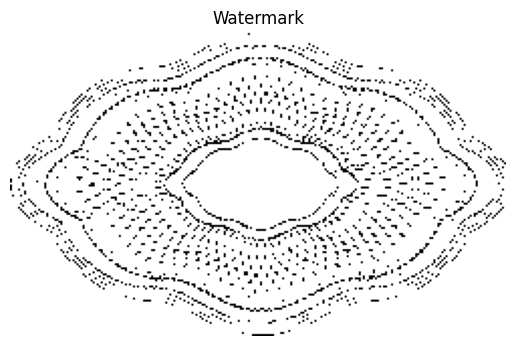

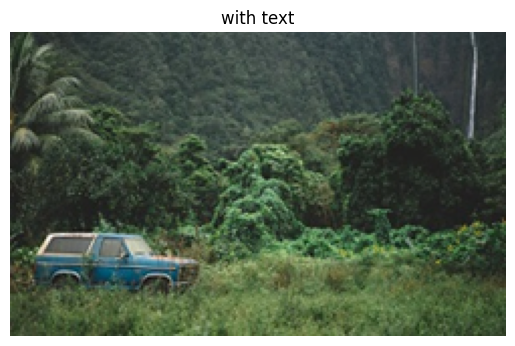

lab


In [26]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(img_path, grayscale=False):
    if grayscale:
        return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    else:
        return cv2.imread(img_path).astype(np.uint8)

def white_black(wm):
    return np.where(wm > 127, 255, 0).astype(np.uint8)

def resize_watermark(img, wm):
    img_height, img_width, _ = img.shape
    wm_height, wm_width = wm.shape
    result = np.zeros((img_height, img_width), dtype=np.uint8)

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = wm[i % wm_height, j % wm_width]
    
    return result

def normalize_watermark(wm):
    return  np.where(np.array(wm) > 127, 255,0).astype(np.uint8)

def insert_watermark(img, wm, bit):
    # вставить фото в какой-то бит 
    picture = img[:, :, 0].copy()
    # наприклад 0001000.. маска буде
    mask = 1 << (bit - 1)

    img_height, img_width = picture.shape
    wm_height, wm_width = wm.shape

    # Iterate through each pixel in the image
    for i in range(img_height):
        for j in range(img_width):
            wm_pixel = wm[i % wm_height, j % wm_width]  # Wrap around if wm is smaller

            # Clear the chosen bit in the original image pixel
            picture[i, j] = (picture[i, j] // 2) * 2  # Clear the bit
            
            # Set the bit according to the watermark value
            if wm_pixel > 0:  # If the watermark pixel is white (255)
                picture[i, j] += mask  # Set the bit to 1

    img[:, :, 0] = picture.astype(np.uint8)
    return img
def extract_watermark(img, bit):
  # извлечь знак из фото по биту
    picture = img[:, :, 0]
    mask = 1 << (bit - 1)

    result = (picture & mask) >> (bit - 1) 
    result = (result * 255).astype(np.uint8)

    return result

def text_to_binary(text):
    result = ''.join(format(ord(char), '08b') for char in text)
    return result

def binary_to_text(binary_text):
    i = [binary_text[i:i + 8] for i in range(0, len(binary_text), 8)]
   
    text = ''.join([chr(int(j, 2)) for j in i if j]) 
    return text

def insert_text(container, text, bit):

    result = text_to_binary(text)
    h_c, w_c, _ = container.shape
    length_text = len(result)

    if h_c*w_c < length_text:
        raise ValueError("The length of the text")
    
    r, g, b = cv2.split(container)
    pic = np.unpackbits(b[:,:,np.newaxis], axis=2)

    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            if result == '':
                break
            pic[i, j, -bit] = result[0]
            result = result[1:]


    b_packed = np.packbits(pic, axis=2)
    b_new = b_packed.reshape(b_packed.shape[0],b_packed.shape[1])

    img_res = cv2.merge((r, g, b_new))
    return img_res, length_text

def extrect_text(container, length_text):
    _, _, b_mod = cv2.split(container)

    b_mod_unpacked = np.unpackbits(b_mod[:,:,np.newaxis], axis=2)

    text = b_mod_unpacked[:,:, -1].flatten()
    result = text[:length_text]

    result = ''.join(map(str, result))
    return binary_to_text(result)


def show_image(img, title):
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

wm_path = "WM.png"
img_path = "InputImage.png"

img = load_image(img_path)
wm = load_image(wm_path, grayscale=True)

wm = white_black(wm)
wm = resize_watermark(img, wm)

wm = normalize_watermark(wm)
print(np.min(wm), np.max(wm))

bit = 1
img_with_wm = insert_watermark(img, wm, bit)
show_image(img_with_wm, title="Image")

extracted_wm = extract_watermark(img_with_wm, bit)
show_image(extracted_wm, title="Watermark")

text = "lab"
img_with_text, leng = insert_text(img_with_wm, text, bit)

show_image(img_with_text, title="with text")

text_enc = extrect_text(img_with_text, leng)
print(text_enc)
# plt.imshow(img_with_text)
# extracted_text = extract_text(img_with_text, bit)
# print("text:", extracted_text)